In [2]:
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm
import re
import time
import csv
import os

# reference 대용량 csv파일 불러오기 트릭
## - 샘플 확인하여 사용할 컬럼 확정

In [3]:
import pandas as pd
import numpy as np

In [ ]:
# Read the first few rows of the CSV file
nrows = 10000  # Number of rows to read for inferring data types
df_sample = pd.read_csv('F:\cluster_test_2024\wos2413db_pkls\combined_df_web_of_science_2413_raw_reference.csv', sep=',', nrows=nrows)

In [ ]:
df_sample

In [ ]:
df_sample.columns

In [6]:
use_cols = ['uid', 'ref_count', 'ref_uid', 'ref_occurence_order','ref_year']

## chunk 사용하여 불러오기

In [8]:
import time

chunksize = 100000000 # 1억 !!!
chunk_list = []  # append each chunk df here 

total_rows = 0
chunk_number = 0

In [9]:
start_time = time.time()
# Read the CSV file in chunks with tqdm progress bar
for chunk in pd.read_csv('F:\cluster_test_2024\wos2413db_pkls\combined_df_web_of_science_2413_raw_reference.csv', sep=',', usecols=use_cols, chunksize=chunksize):
    chunk_number += 1
    total_rows += len(chunk)
    chunk_list.append(chunk)
    
    elapsed_time = time.time() - start_time
    
    print(f"Chunk number: {chunk_number}, Elapsed time: {elapsed_time:.2f} seconds, Total rows: {total_rows}")

# Concatenate all chunks into one DataFrame (if needed)
df = pd.concat(chunk_list)
#shape (1, 1594398232)

Chunk number: 1, Elapsed time: 106.83 seconds, Total rows: 100000000
Chunk number: 2, Elapsed time: 214.15 seconds, Total rows: 200000000
Chunk number: 3, Elapsed time: 325.11 seconds, Total rows: 300000000
Chunk number: 4, Elapsed time: 435.74 seconds, Total rows: 400000000
Chunk number: 5, Elapsed time: 547.29 seconds, Total rows: 500000000
Chunk number: 6, Elapsed time: 657.37 seconds, Total rows: 600000000
Chunk number: 7, Elapsed time: 768.16 seconds, Total rows: 700000000
Chunk number: 8, Elapsed time: 879.13 seconds, Total rows: 800000000
Chunk number: 9, Elapsed time: 994.91 seconds, Total rows: 900000000
Chunk number: 10, Elapsed time: 1107.13 seconds, Total rows: 1000000000
Chunk number: 11, Elapsed time: 1221.18 seconds, Total rows: 1100000000
Chunk number: 12, Elapsed time: 1338.09 seconds, Total rows: 1200000000
Chunk number: 13, Elapsed time: 1455.35 seconds, Total rows: 1300000000
Chunk number: 14, Elapsed time: 1572.98 seconds, Total rows: 1400000000
Chunk number: 15, E

In [10]:
df.shape

(1594398232, 5)

In [11]:
# 데이터프레임이름 업데이트
df_refer = df



# Citation Speed (CS, 인용속도) 계산하기

## 2018 10대기술 검색결과 불러오기

In [57]:
# 기본 경로 지정
base_path = 'F:/cluster_test_2024/search_results_2024_06-04_combined'

# 결과를 저장할 딕셔너리 초기화
df_combined_dict = {}

# 모든 파일을 검색하여 딕셔너리에 저장
for filename in os.listdir(base_path):
    if filename.endswith('_aukey_or_abs_search_results_textinfo.csv'):
        # 파일의 전체 경로
        file_path = os.path.join(base_path, filename)
        
        # 파일명에서 '_aukey_or_abs_search_results_textinfo.csv'를 제외한 앞부분을 키로 사용
        key = filename.replace('_aukey_or_abs_search_results_textinfo.csv', '')
        
        # CSV 파일을 데이터프레임으로 읽어와 딕셔너리에 저장
        df_combined_dict[key] = pd.read_csv(file_path)

# 결과 확인
for key, df in df_combined_dict.items():
    print(f"Key: {key}, DataFrame Shape: {df.shape}")


Key: 1-1. 금속 3D 프린팅(A-set)3, DataFrame Shape: (795, 6)
Key: 1-1. 금속 3D 프린팅(A-set)gpt, DataFrame Shape: (8014, 6)
Key: 1-1. 금속 3D 프린팅(A-set)gpt_smaller, DataFrame Shape: (710, 6)
Key: 1-2. 금속 3D 프린팅(B-set)gpt, DataFrame Shape: (959, 6)
Key: 1-2. 금속 3D 프린팅(B-set), DataFrame Shape: (5276, 6)
Key: 10. 상변화 소재 활용 열에너지 저장, DataFrame Shape: (22460, 6)
Key: 2. 신축성 전자소자, DataFrame Shape: (135734, 6)
Key: 3. 휴먼 마이크로바이옴, DataFrame Shape: (75630, 6)
Key: 4. 암 진단_예측 바이오마커, DataFrame Shape: (157015, 6)
Key: 5. 유전자 편집, DataFrame Shape: (59997, 6)
Key: 6.무선 전력 전송, DataFrame Shape: (6729, 6)
Key: 7. 초대용량 데이터 대응 광통신 기술, DataFrame Shape: (22242, 6)
Key: 7. 초대용량 데이터 대응 광통신 기술_gpt, DataFrame Shape: (1304, 6)
Key: 8. 면역세포치료, DataFrame Shape: (96932, 6)
Key: 9. 나노유체 이용 에너지 효율화, DataFrame Shape: (32067, 6)


In [58]:
len(df_combined_dict)

15

In [51]:
# 함수 정의: 각 'pubyear' 그룹에 대해 필요한 계산을 수행
def compute_statistics(df):
    grouped_by_uid = df.groupby('uid').agg({
        'firstCitingYear': ['min'],
        'citing_year': ['mean']
    })
    grouped_by_uid.columns = ['min_citing_year', 'mean_citing_year']
    
    min_citing_year_avg = grouped_by_uid['min_citing_year'].mean()
    mean_citing_year_avg = grouped_by_uid['mean_citing_year'].mean()

    # 필터링: 출판 연도 + 4년 이내에 첫 인용된 문서
    df_filtered = df[df['firstCitingYear'] <= df['pubyear'] + 4]

    # 지수 함수 값 계산
    df_filtered['exp_term'] = np.exp(-(df_filtered['firstCitingYear'] - df_filtered['pubyear']))

    # 분자 계산
    numerator = df_filtered['exp_term'].sum()

    # 분모 계산
    denominator = df_filtered.shape[0]

    # 수식 계산
    Citation_speed = numerator / denominator if denominator != 0 else 0
    
    return pd.Series({
        'min_citing_year_avg': min_citing_year_avg,
        'mean_citing_year_avg': mean_citing_year_avg,
        'Citation_speed': Citation_speed
    })

# 피인용 확인
## 분석대상 기술별

In [22]:
# uid_y를 pub_info에서 citing_year를 찾아야 한다.
df_pubinfo = pd.read_pickle('F:\cluster_test_2024\wos2413db_pkls\combined_df_web_of_science_2413_raw_pub_info_update23.pkl')

In [30]:
df_pubinfo_year = df_pubinfo[['uid','pubyear']]

In [31]:
df_pubinfo_year.columns = ['citing_uid', 'citing_year']

In [87]:
# CS 지표를 저장할 딕셔너리 초기화
cs_dict_yearly = {}
result_dict_yearly = {}
print(f'Start time: {elapsed_time:.2f} seconds')

for key in df_combined_dict.keys():
    start_time = time.time()  # 시작 시간 기록
    print(f'now: {key}')
    df_cited = df_combined_dict[key][['uid','pubyear']]
    # df_cited uid 추출
    uids = df_cited['uid'].unique()
    # df_refer에서 같은 uid를 가진 행 추출
    df_refer_filtered = df_refer[df_refer['ref_uid'].isin(uids)]
    df_refer_filtered.columns = ['citing_uid', 'ref_count', 'uid', 'ref_occurence_order', 'pubyear']
    df_citation_pair = df_refer_filtered[['uid', 'pubyear', 'citing_uid']]
    df_citation_pair_with_year = df_citation_pair.merge(df_pubinfo_year, left_on='citing_uid', right_on='citing_uid', how='inner')
    
    # 'pubyear'별로 그룹화하여 계산
    grouped = df_citation_pair_with_year.groupby('pubyear')
    
    # firstCitingYear 계산
    df_first_citing_year = df_citation_pair_with_year.groupby('uid')['citing_year'].min().reset_index()
    df_first_citing_year.columns = ['uid', 'firstCitingYear']

    # 원본 데이터프레임과 병합
    df_combined = pd.merge(df_citation_pair_with_year, df_first_citing_year, on='uid')
    
    # 'pubyear'별로 그룹화하여 계산
    grouped = df_combined.groupby('pubyear')
    result = grouped.apply(compute_statistics).reset_index()
    
    # 결과를 딕셔너리에 저장
    result_dict_yearly[key] = result
    cs_dict_yearly[key] = result[['pubyear','Citation_speed']]

    end_time = time.time()  # 종료 시간 기록
    elapsed_time = end_time - start_time  # 소요 시간 계산
    print(f'Time taken for {key}: {elapsed_time:.2f} seconds')

Start time: 1803.74 seconds
now: 1-1. 금속 3D 프린팅(A-set)3
Time taken for 1-1. 금속 3D 프린팅(A-set)3: 117.87 seconds
now: 1-1. 금속 3D 프린팅(A-set)gpt
Time taken for 1-1. 금속 3D 프린팅(A-set)gpt: 175.53 seconds
now: 1-1. 금속 3D 프린팅(A-set)gpt_smaller
Time taken for 1-1. 금속 3D 프린팅(A-set)gpt_smaller: 168.85 seconds
now: 1-2. 금속 3D 프린팅(B-set)gpt
Time taken for 1-2. 금속 3D 프린팅(B-set)gpt: 130.19 seconds
now: 1-2. 금속 3D 프린팅(B-set)
Time taken for 1-2. 금속 3D 프린팅(B-set): 205.15 seconds
now: 10. 상변화 소재 활용 열에너지 저장
Time taken for 10. 상변화 소재 활용 열에너지 저장: 263.56 seconds
now: 2. 신축성 전자소자
Time taken for 2. 신축성 전자소자: 257.20 seconds
now: 3. 휴먼 마이크로바이옴
Time taken for 3. 휴먼 마이크로바이옴: 252.03 seconds
now: 4. 암 진단_예측 바이오마커
Time taken for 4. 암 진단_예측 바이오마커: 311.63 seconds
now: 5. 유전자 편집
Time taken for 5. 유전자 편집: 190.02 seconds
now: 6.무선 전력 전송
Time taken for 6.무선 전력 전송: 149.60 seconds
now: 7. 초대용량 데이터 대응 광통신 기술
Time taken for 7. 초대용량 데이터 대응 광통신 기술: 263.07 seconds
now: 7. 초대용량 데이터 대응 광통신 기술_gpt
Time taken for 7. 초대용량 데이터 대응 광통신 기술_

C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 47536 (\N{HANGUL SYLLABLE RIN}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 54021 (\N{HANGUL SYLLABLE TING}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
C

C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from current font.
  plt.tight_layout()
C:\U

F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47308 (\N

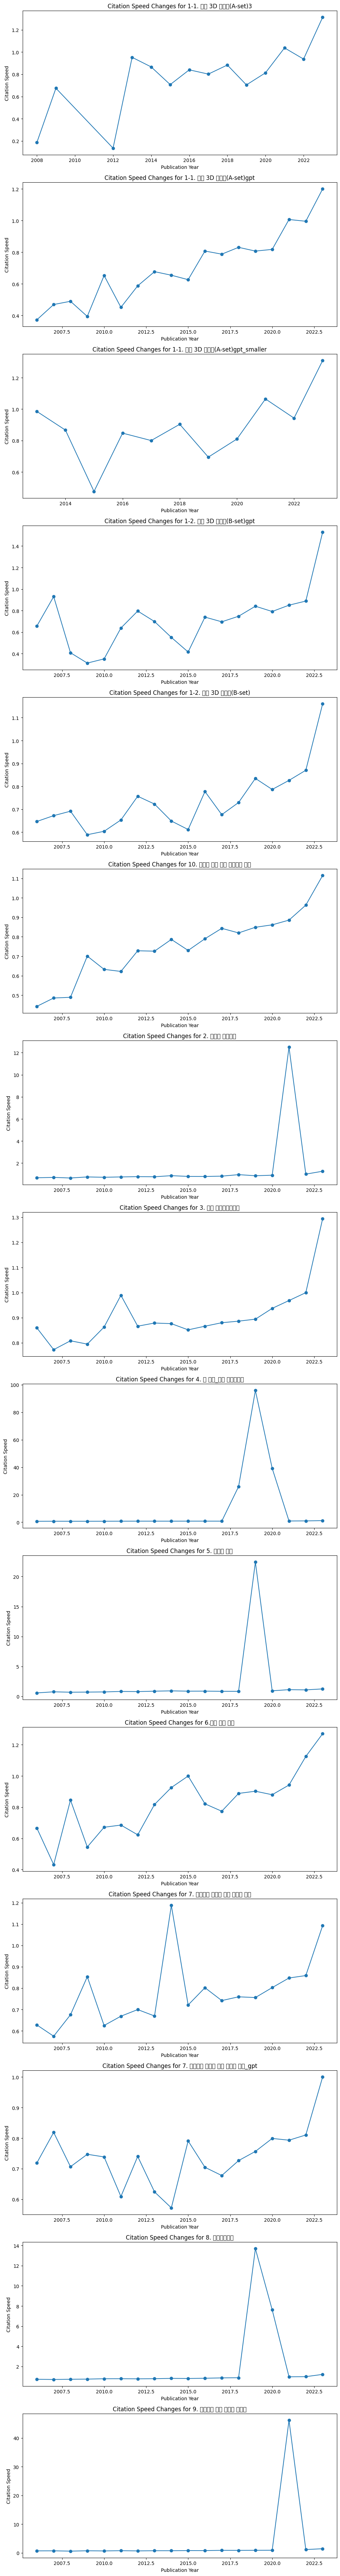

In [88]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

# 연도별 Citation_speed 값을 저장할 리스트
citation_speeds = [result_dict_yearly[key][['pubyear', 'Citation_speed']] for key in result_dict_yearly.keys()]

# 서브플롯 생성
N = len(citation_speeds)
fig, axs = plt.subplots(N, 1, figsize=(10, N * 5))

for i, citation_speed_df in enumerate(citation_speeds):
    axs[i].plot(citation_speed_df['pubyear'], citation_speed_df['Citation_speed'], marker='o')
    axs[i].set_title(f'Citation Speed Changes for {list(result_dict_yearly.keys())[i]}')
    axs[i].set_xlabel('Publication Year')
    axs[i].set_ylabel('Citation Speed')

plt.tight_layout()
plt.show()

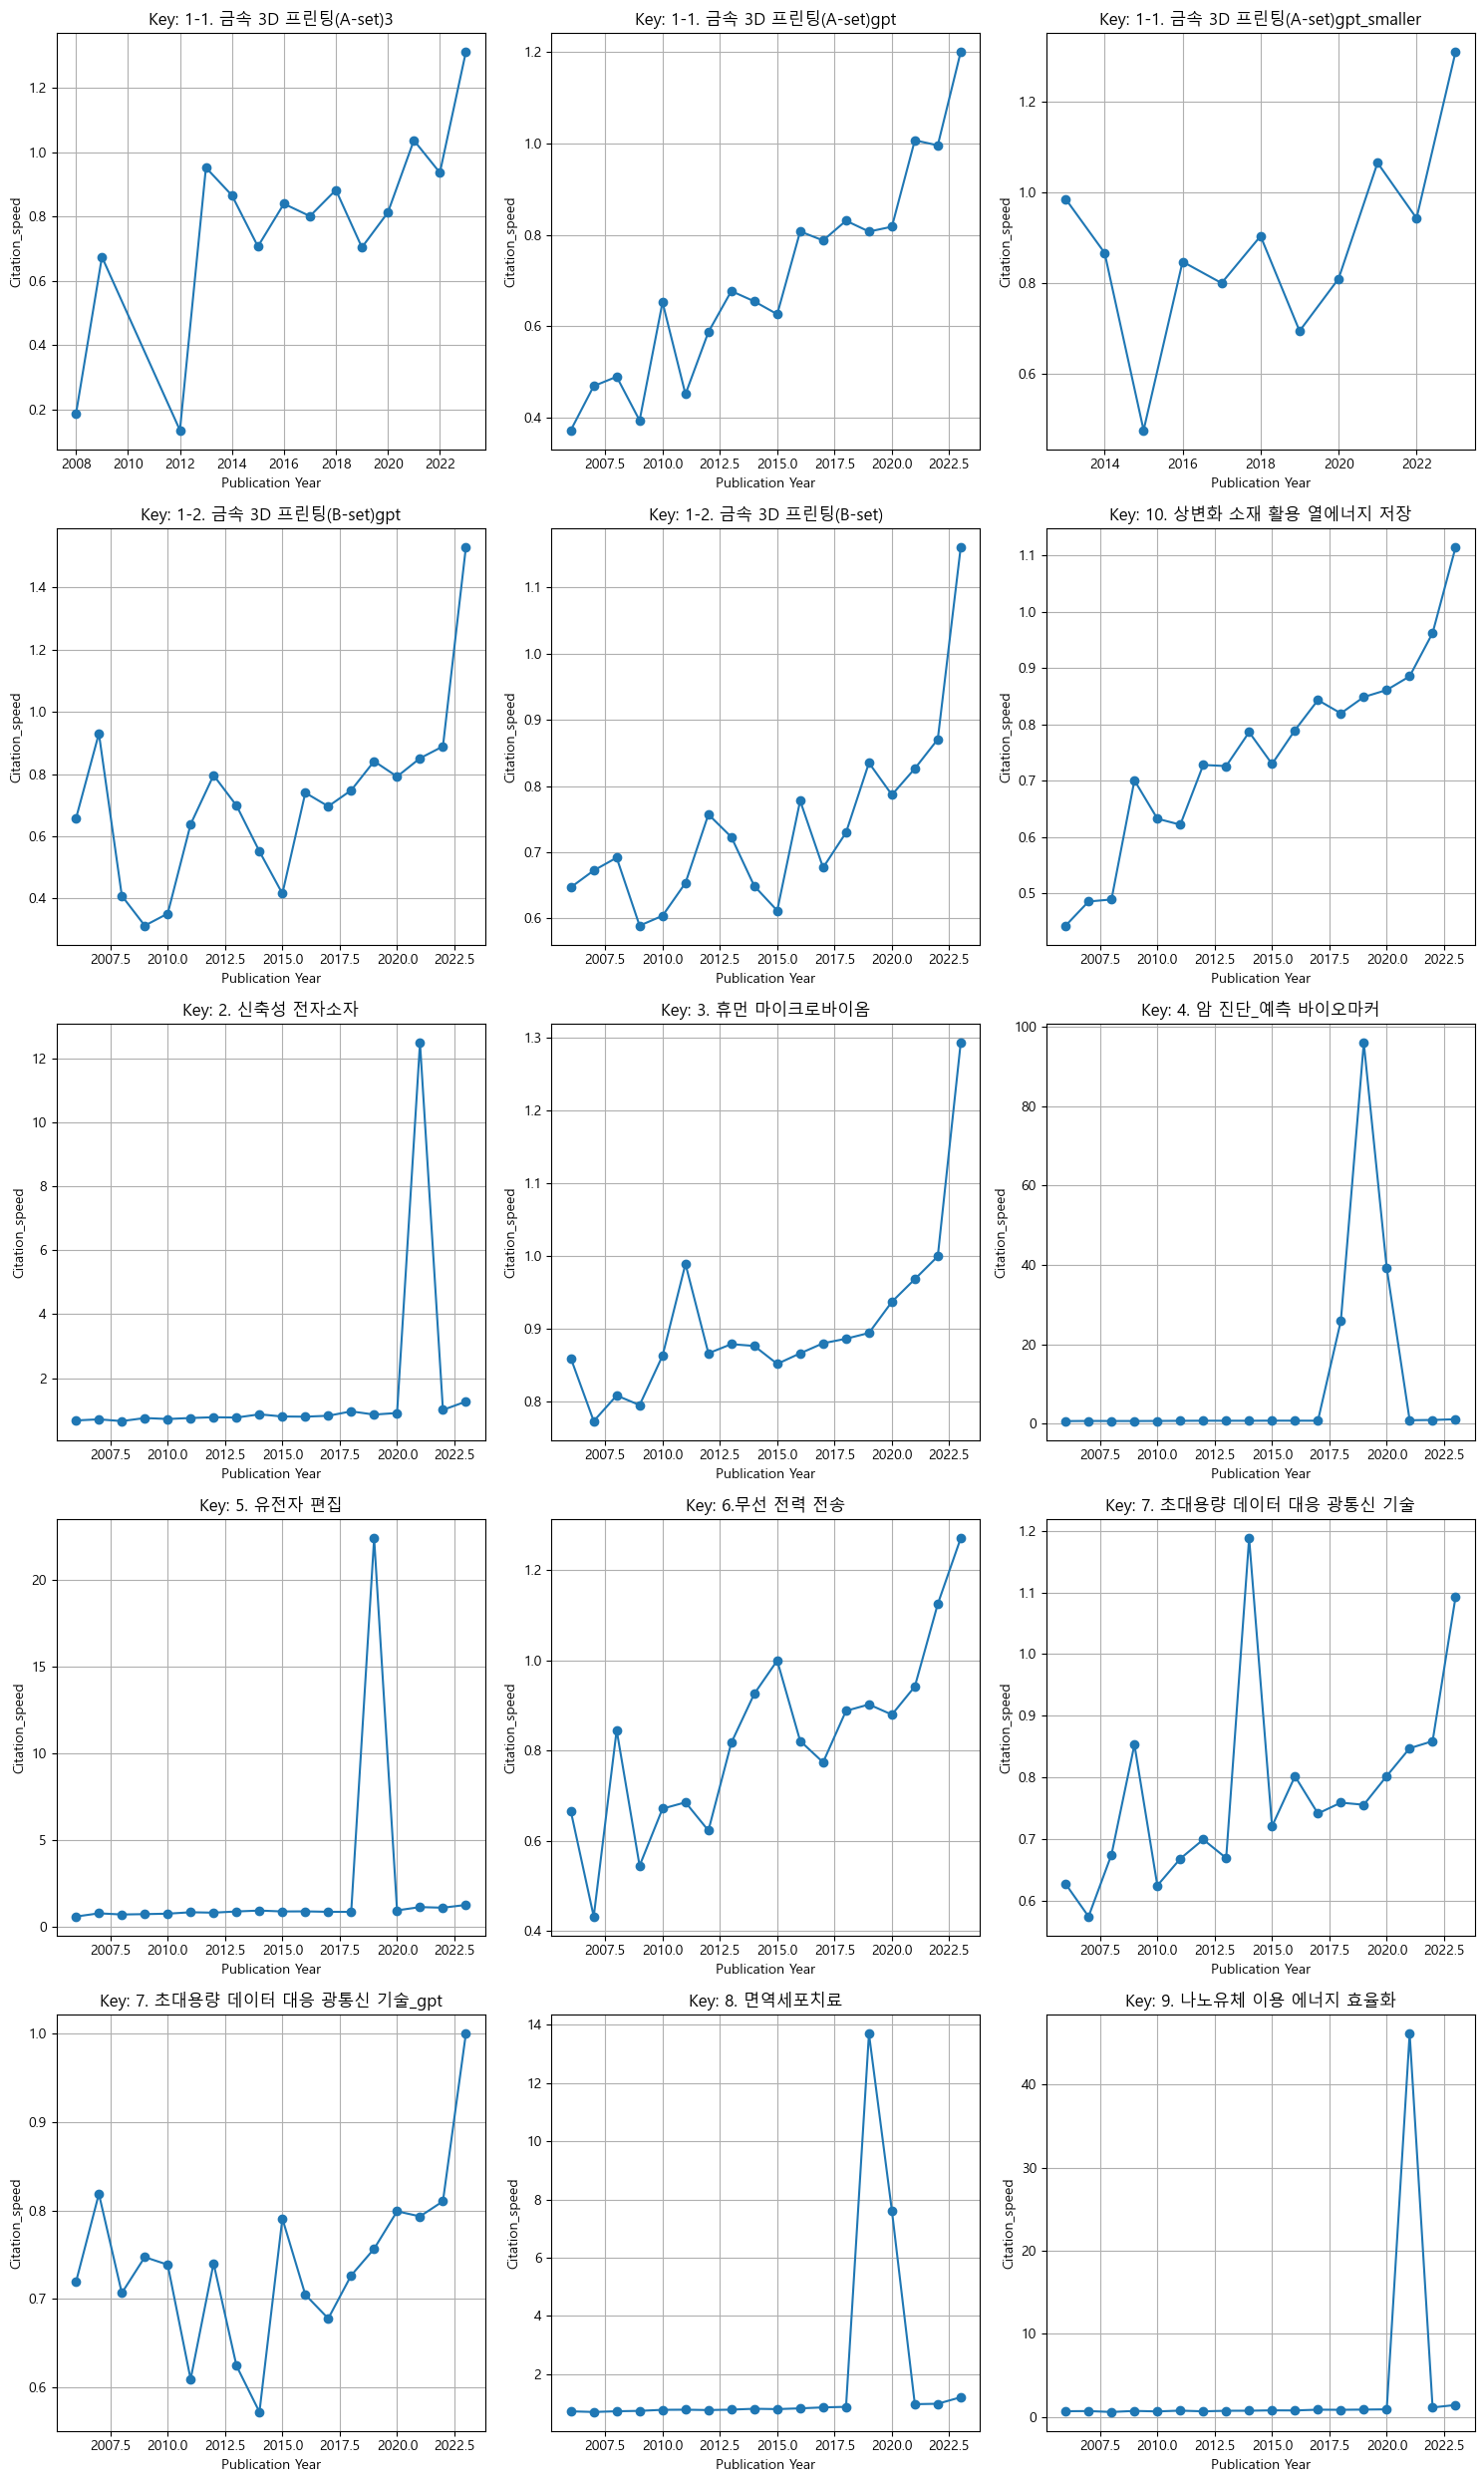

In [91]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 맑은 고딕 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 서브플롯 생성
n_keys = len(cs_dict_yearly)
ncols = 3
nrows = (n_keys + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

# 각 key에 대해 그래프 생성
for i, (key, cs_df) in enumerate(cs_dict_yearly.items()):
    ax = axes[i]
    ax.plot(cs_df['pubyear'], cs_df['Citation_speed'], marker='o', linestyle='-')
    ax.set_title(f'Key: {key}')
    ax.set_xlabel('Publication Year')
    ax.set_ylabel('Citation_speed')
    ax.grid(True)

# 빈 서브플롯 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [62]:
# df_cited uid 추출
uids = df_cited['uid'].unique()

In [75]:
# df_refer에서 같은 uid를 가진 행 추출
df_refer_filtered = df_refer[df_refer['ref_uid'].isin(uids)]

In [78]:
df_refer_filtered.columns = ['citing_uid', 'ref_count', 'uid', 'ref_occurence_order', 'pubyear']

In [79]:
df_citation_pair = df_refer_filtered[['uid', 'pubyear', 'citing_uid']]

In [32]:
#df_citation_pair = df_merged[['uid', 'pubyear', 'citing_uid']]

In [33]:
df_citation_pair_with_year = df_citation_pair.merge(df_pubinfo_year, left_on='citing_uid', right_on='citing_uid', how='inner')

In [34]:
df_citation_pair_with_year

,uid,pubyear,citing_uid,citing_year
0,WOS:000252621500008,2008,WOS:000272563900012,2009
1,WOS:000252621500008,2008,WOS:000275929800135,2009
2,WOS:000252621500008,2008,WOS:000283121300007,2010
3,WOS:000252621500008,2008,WOS:000276004500113,2010
4,WOS:000252621500008,2008,WOS:000288304400013,2011
...,...,...,...,...
160198,WOS:000937195600001,2023,WOS:001017873400001,2023
160199,WOS:000937195600001,2023,WOS:001133762500148,2023
160200,WOS:001087772400011,2023,WOS:001092074700001,2023
160201,WOS:001087772400011,2023,WOS:001078506200001,2023


In [36]:
# 'pubyear'별로 그룹화하여 계산
grouped = df_citation_pair_with_year.groupby('pubyear')

In [43]:
# firstCitingYear 계산
df_first_citing_year = df_citation_pair_with_year.groupby('uid')['citing_year'].min().reset_index()
df_first_citing_year.columns = ['uid', 'firstCitingYear']

# 원본 데이터프레임과 병합
df_combined = pd.merge(df_citation_pair_with_year, df_first_citing_year, on='uid')

In [83]:
df_combined

,uid,pubyear
0,WOS:000252621500008,2008
1,WOS:000258025700008,2008
2,WOS:000272266900007,2009
3,WOS:000268339100031,2009
4,WOS:000267697500048,2009
...,...,...
6724,WOS:000947678100001,2023
6725,WOS:000984243000001,2023
6726,WOS:001124167400013,2023
6727,WOS:001128031700093,2023


In [52]:
# 'pubyear'별로 그룹화하여 계산
grouped = df_combined.groupby('pubyear')
result = grouped.apply(compute_statistics).reset_index()

In [53]:
result

,pubyear,min_citing_year_avg,mean_citing_year_avg,Citation_speed
0,2006,2007.333333,2013.880935,0.666090
1,2007,2008.125000,2014.865587,0.432377
2,2008,2010.307692,2014.925452,0.845373
3,2009,2010.052632,2015.362803,0.544914
4,2010,2010.956522,2015.989819,0.671402
5,2011,2011.936170,2016.697755,0.685387
6,2012,2013.268293,2017.336868,0.622888
7,2013,2014.156028,2017.791854,0.817371
8,2014,2014.906250,2018.371055,0.925864
9,2015,2015.889632,2019.063788,0.999531


In [47]:
df_citation_pair_with_year[df_citation_pair_with_year['pubyear']==2023]

,uid,pubyear,citing_uid,citing_year
1750,WOS:000965436200001,2023,WOS:000873813400001,2022
1835,WOS:000965610300001,2023,WOS:001068815100021,2023
1836,WOS:000975959600035,2023,WOS:001068815100021,2023
1846,WOS:000967109300001,2023,WOS:001057915500052,2023
1847,WOS:000966111000001,2023,WOS:001057915500052,2023
...,...,...,...,...
160198,WOS:000937195600001,2023,WOS:001017873400001,2023
160199,WOS:000937195600001,2023,WOS:001133762500148,2023
160200,WOS:001087772400011,2023,WOS:001092074700001,2023
160201,WOS:001087772400011,2023,WOS:001078506200001,2023


In [ ]:
# TCT 지표를 저장할 딕셔너리 초기화
tct_dict = {}

for key in tqdm(df_combined_dict.keys()):
    df_combined = df_combined_dict[key]
    df_refer = df_refer_dict[key]
    
    # 각 문서의 pubyear와 참조 문서의 ref_year 차이 계산
    merged_df = df_combined.merge(df_refer[['uid', 'ref_year']], left_on='uid', right_on='uid', how='inner')
    merged_df['year_diff'] = merged_df['pubyear'] - merged_df['ref_year']
    
    # 각 문서(uid)별로 year_diff의 중앙값 계산
    median_diffs = merged_df.groupby('uid')['year_diff'].median().reset_index()
    median_diffs.columns = ['uid', 'median_diff']
    
    # 각 key별로 문서들의 중앙값의 평균 계산
    tct_value = median_diffs['median_diff'].mean()
    tct_dict[key] = tct_value

# 결과 확인
for key, value in tct_dict.items():
    print(f"Key: {key}, TCT: {value}")


In [ ]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 맑은 고딕 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# TCT 지표를 저장할 딕셔너리 초기화
tct_dict_yearly = {}

for key in tqdm(df_combined_dict.keys()):
    df_combined = df_combined_dict[key]
    df_refer = df_refer_dict[key]
    
    # 각 문서의 pubyear와 참조 문서의 ref_year 차이 계산
    merged_df = df_combined.merge(df_refer[['uid', 'ref_year']], left_on='uid', right_on='uid', how='inner')
    merged_df['year_diff'] = merged_df['pubyear'] - merged_df['ref_year']
    
    # 각 연도별로 uid 그룹화 후 year_diff의 중앙값 계산
    yearly_medians = merged_df.groupby(['pubyear', 'uid'])['year_diff'].median().reset_index()
    yearly_tct = yearly_medians.groupby('pubyear')['year_diff'].mean().reset_index()
    yearly_tct.columns = ['pubyear', 'tct']
    
    # 결과를 딕셔너리에 저장
    tct_dict_yearly[key] = yearly_tct

# 서브플롯 생성
n_keys = len(tct_dict_yearly)
ncols = 3
nrows = (n_keys + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

# 각 key에 대해 그래프 생성
for i, (key, tct_df) in enumerate(tct_dict_yearly.items()):
    ax = axes[i]
    ax.plot(tct_df['pubyear'], tct_df['tct'], marker='o', linestyle='-')
    ax.set_title(f'Key: {key}')
    ax.set_xlabel('Publication Year')
    ax.set_ylabel('TCT')
    ax.grid(True)

# 빈 서브플롯 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# 피인용 기반 지표 계산하기.
# CS : Citation Speed, 인용속도. 논문이 출판된 이후 처음 인용된 연도의 평균.
# df_combined_dict
# df_refer

In [ ]:
df_combined_dict.keys()

In [ ]:
df_combined_dict['5. 유전자 편집']

In [ ]:
df_refer.head()

In [ ]:
df_refer.shape